In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

import geopandas as gpd
from geobr import read_municipality, read_state
from shapely.geometry import Point
from shapely.ops import unary_union

# EAC4 Pollutants (2010-2024)

In [ ]:
"""
Processamento de gases traço (CAMS – ECMFW Atmospheric Composition Reanalysis 4, EAC4)

Etapas do processamento:
1. Leitura do NetCDF contendo concentrações de gases traço do CAMS.
2. Conversão das longitudes do intervalo [0, 360] para [-180, 180],
   garantindo consistência geográfica com ERA5 e outros produtos.
3. Reordenação das longitudes para manter continuidade espacial.
4. Conversão das concentrações de razão de mistura (kg/kg) para
   concentração em massa (µg m⁻³), assumindo densidade do ar constante.
5. Conversão do Dataset final para DataFrame para análise estatística.

Fonte dos dados:
- Copernicus Atmosphere Monitoring Service (CAMS)
- ECMFW Atmospheric Composition Reanalysis 4 (EAC4)
"""

ds = xr.open_dataset(r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\EAC4\pollutants_gases_2010.nc")

# Converter longitudes de 0–360 para -180–180
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
# Ordenar as longitudes para manter ordem geográfica correta
ds = ds.sortby(ds.longitude)

# rho_air = 1.225  # kg/m³
# ds_ugm3 = ds * rho_air * 1e9
# for v in ds_ugm3.data_vars:
#     ds_ugm3[v].attrs["units"] = "µg m-3"

df_aqi = ds.to_dataframe().reset_index()
ds.close()
df_aqi

,valid_time,model_level,latitude,longitude,go3,no2,so2,co
0,2010-01-01 00:00:00,60.0,-14.5,-58.00,1.384579e-08,3.828197e-10,5.183508e-11,1.363492e-07
1,2010-01-01 00:00:00,60.0,-14.5,-57.25,1.113198e-08,7.311767e-10,7.479272e-11,1.408697e-07
2,2010-01-01 00:00:00,60.0,-14.5,-56.50,1.114612e-08,7.560581e-10,6.702960e-11,1.422255e-07
3,2010-01-01 00:00:00,60.0,-14.5,-55.75,1.130205e-08,5.499030e-10,3.915101e-11,1.421041e-07
4,2010-01-01 00:00:00,60.0,-14.5,-55.00,9.737395e-09,9.519157e-10,2.572219e-11,1.420641e-07
...,...,...,...,...,...,...,...,...
2049835,2010-12-31 21:00:00,60.0,-34.0,-42.25,2.526150e-08,1.504242e-11,4.501665e-11,5.296522e-08
2049836,2010-12-31 21:00:00,60.0,-34.0,-41.50,2.539018e-08,1.540191e-11,5.687516e-11,5.300761e-08
2049837,2010-12-31 21:00:00,60.0,-34.0,-40.75,2.548988e-08,1.589308e-11,6.139022e-11,5.322343e-08
2049838,2010-12-31 21:00:00,60.0,-34.0,-40.00,2.554818e-08,1.519874e-11,7.001177e-11,5.338093e-08


In [17]:
def load_cams_gases(path_nc):
    ds = xr.open_dataset(path_nc)

    # converter longitudes 0–360 -> -180–180
    ds = ds.assign_coords(
        longitude=(((ds.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    # opcional: conversão kg/kg -> µg m-3
    # rho_air = 1.225  # kg m-3
    # ds = ds * rho_air * 1e9
    # for v in ds.data_vars:
    #     ds[v].attrs["units"] = "µg m-3"

    df = ds.to_dataframe().reset_index()
    ds.close()
    return df

def load_cams_pm(path_nc):
    ds = xr.open_dataset(path_nc)

    ds = ds.assign_coords(
        longitude=(((ds.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    df = ds.to_dataframe().reset_index()
    ds.close()
    return df

base_cams = Path(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\EAC4"
)

dfs_aqi = []

for year in range(2010, 2025):
    print(f"Lendo CAMS {year}...")

    gases = load_cams_gases(base_cams / f"pollutants_gases_{year}.nc")
    pm    = load_cams_pm(base_cams / f"pollutants_pm_{year}.nc")

    # merge gases + PM
    aqi_year = gases.merge(
        pm,
        on=["valid_time", "latitude", "longitude"],
        how="outer"
    )

    dfs_aqi.append(aqi_year)

df_aqi = pd.concat(dfs_aqi, ignore_index=True)

Lendo CAMS 2010...
Lendo CAMS 2011...
Lendo CAMS 2012...
Lendo CAMS 2013...
Lendo CAMS 2014...
Lendo CAMS 2015...
Lendo CAMS 2016...
Lendo CAMS 2017...
Lendo CAMS 2018...
Lendo CAMS 2019...
Lendo CAMS 2020...
Lendo CAMS 2021...
Lendo CAMS 2022...
Lendo CAMS 2023...
Lendo CAMS 2024...


# ERA5 Meteorology (2010-2024)

In [19]:
"""
Variáveis meteorológicas utilizadas (ERA5 – single levels)

Dimensões:
- valid_time : tempo UTC (3-horário)
- latitude   : graus decimais (positivo norte)
- longitude  : graus decimais (positivo leste)

Variáveis originais ERA5:
- u10   : componente zonal do vento a 10 m [m s-1]
          (positivo de oeste para leste)
- v10   : componente meridional do vento a 10 m [m s-1]
          (positivo de sul para norte)

- t2m   : temperatura do ar a 2 m [K]
- d2m   : temperatura do ponto de orvalho a 2 m [K]

- ssrd  : radiação solar descendente na superfície acumulada
          desde 00 UTC [J m-2]

- blh   : altura da camada limite atmosférica [m]

Variáveis derivadas:
- wind_speed : velocidade do vento a 10 m
               sqrt(u10² + v10²) [m s-1]

- ssrd_flux  : fluxo médio de radiação solar descendente
               calculado por diferença temporal da ssrd
               (intervalo de 3 h = 10800 s) [W m-2]

- RH         : umidade relativa a 2 m [%]
               calculada a partir de t2m e d2m
               segundo formulação padrão WMO

Variáveis técnicas removidas:
- number : índice do membro do ensemble (fixo = 0 no ERA5)
- expver : versão interna do experimento ECMWF
"""

# ------------------------------
# Abrir dataset
# ------------------------------
ds = xr.open_dataset(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\ERA5\meteo_era5_201001.nc"
)

# ------------------------------
# Radiação solar (J/m² -> W/m²)
# ------------------------------
# duração do intervalo (3 horas)
DT = 3 * 3600  # segundos

# diferença temporal
dssrd = ds["ssrd"].diff("valid_time")

# corrigir resets:
# quando a diferença é negativa, usar o valor acumulado atual
dssrd_corrected = xr.where(
    dssrd >= 0,
    dssrd,
    ds["ssrd"].isel(valid_time=slice(1, None))
)

# converter para fluxo médio
ds["ssrd_flux"] = dssrd_corrected / DT

# atributos (boa prática)
ds["ssrd_flux"].attrs["units"] = "W m-2"
ds["ssrd_flux"].attrs["long_name"] = "Surface solar radiation downward (mean flux over 3h)"

# ------------------------------
# Velocidade do vento
# ------------------------------
ds["wind_speed"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
ds["wind_speed"].attrs["units"] = "m s-1"
ds["wind_speed"].attrs["long_name"] = "10 m wind speed"

# ------------------------------
# Umidade relativa (%)
# ------------------------------
RH = mpcalc.relative_humidity_from_dewpoint(
    ds["t2m"] * units.kelvin,
    ds["d2m"] * units.kelvin
)

ds["RH"] = RH.metpy.dequantify() * 100
ds["RH"].attrs["units"] = "%"
ds["RH"].attrs["long_name"] = "Relative humidity at 2 m"

# ------------------------------
# Limpeza
# ------------------------------
ds = ds.drop_vars(["number", "expver"])

# ------------------------------
# Converter para DataFrame
# ------------------------------
df_meteo = ds.to_dataframe().reset_index()

ds.close()
df_meteo

,valid_time,latitude,longitude,ssrd,u10,v10,t2m,d2m,blh,ssrd_flux,wind_speed,RH
0,2010-01-01 00:00:00,-14.5,-58.00,0.0,2.332703,-1.822403,297.931152,294.382812,618.560547,NaN,2.960178,80.697075
1,2010-01-01 00:00:00,-14.5,-57.25,0.0,1.009460,-1.395645,298.688965,295.449219,295.498047,NaN,1.722450,82.329346
2,2010-01-01 00:00:00,-14.5,-56.50,0.0,1.276062,-0.833145,297.546387,295.589844,318.998047,NaN,1.523964,88.880394
3,2010-01-01 00:00:00,-14.5,-55.75,0.0,-0.223938,-1.069473,297.569824,295.843750,49.935532,NaN,1.092667,90.132980
4,2010-01-01 00:00:00,-14.5,-55.00,0.0,-0.118469,-0.898575,296.722168,295.466797,46.685532,NaN,0.906351,92.689796
...,...,...,...,...,...,...,...,...,...,...,...,...
174091,2010-01-31 21:00:00,-34.0,-42.25,690816.0,0.399445,-4.272995,296.268799,295.137207,332.934845,63.964443,4.291625,93.366760
174092,2010-01-31 21:00:00,-34.0,-41.50,734848.0,-0.077118,-4.863815,296.198486,295.223145,293.809845,68.041481,4.864427,94.256065
174093,2010-01-31 21:00:00,-34.0,-40.75,725568.0,-0.292938,-4.859909,295.639893,294.785645,267.559845,67.182220,4.868730,94.932098
174094,2010-01-31 21:00:00,-34.0,-40.00,697216.0,-0.027313,-4.841354,295.569580,294.814941,313.309845,64.557037,4.841432,95.508804


In [20]:
base_path = Path(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\raw\ERA5"
)

dfs_meteo = []
DT = 3 * 3600  # 3 horas em segundos

for year in range(2010, 2025):
    for month in range(1, 13):
        file = base_path / f"meteo_era5_{year}{month:02d}.nc"
        if not file.exists():
            continue

        print(f"Lendo ERA5 {year}{month:02d}")

        ds = xr.open_dataset(file)

        # ----------------------
        # SSRD -> fluxo médio
        # ----------------------
        dssrd = ds["ssrd"].diff("valid_time")

        dssrd_corrected = xr.where(
            dssrd >= 0,
            dssrd,
            ds["ssrd"].isel(valid_time=slice(1, None))
        )

        ds["ssrd_flux"] = dssrd_corrected / DT
        ds["ssrd_flux"].attrs["units"] = "W m-2"

        # ----------------------
        # Velocidade do vento
        # ----------------------
        ds["wind_speed"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
        ds["wind_speed"].attrs["units"] = "m s-1"

        # ----------------------
        # Umidade relativa
        # ----------------------
        RH = mpcalc.relative_humidity_from_dewpoint(
            ds["t2m"] * units.kelvin,
            ds["d2m"] * units.kelvin
        )
        ds["RH"] = RH.metpy.dequantify() * 100
        ds["RH"].attrs["units"] = "%"

        # ----------------------
        # Limpeza
        # ----------------------
        ds = ds.drop_vars(["number", "expver"])

        df = ds.to_dataframe().reset_index()
        dfs_meteo.append(df)

        ds.close()

df_meteo = pd.concat(dfs_meteo, ignore_index=True)
print("ERA5 finalizado:", df_meteo.shape)

Lendo ERA5 201001
Lendo ERA5 201002
Lendo ERA5 201003
Lendo ERA5 201004
Lendo ERA5 201005
Lendo ERA5 201006
Lendo ERA5 201007
Lendo ERA5 201008
Lendo ERA5 201009
Lendo ERA5 201010
Lendo ERA5 201011
Lendo ERA5 201012
Lendo ERA5 201101
Lendo ERA5 201102
Lendo ERA5 201103
Lendo ERA5 201104
Lendo ERA5 201105
Lendo ERA5 201106
Lendo ERA5 201107
Lendo ERA5 201108
Lendo ERA5 201109
Lendo ERA5 201110
Lendo ERA5 201111
Lendo ERA5 201112
Lendo ERA5 201201
Lendo ERA5 201202
Lendo ERA5 201203
Lendo ERA5 201204
Lendo ERA5 201205
Lendo ERA5 201206
Lendo ERA5 201207
Lendo ERA5 201208
Lendo ERA5 201209
Lendo ERA5 201210
Lendo ERA5 201211
Lendo ERA5 201212
Lendo ERA5 201301
Lendo ERA5 201302
Lendo ERA5 201303
Lendo ERA5 201304
Lendo ERA5 201305
Lendo ERA5 201306
Lendo ERA5 201307
Lendo ERA5 201308
Lendo ERA5 201309
Lendo ERA5 201310
Lendo ERA5 201311
Lendo ERA5 201312
Lendo ERA5 201401
Lendo ERA5 201402
Lendo ERA5 201403
Lendo ERA5 201404
Lendo ERA5 201405
Lendo ERA5 201406
Lendo ERA5 201407
Lendo ERA5

# Merge

In [21]:
# garantir tipos consistentes
for col in ["latitude", "longitude"]:
    df_aqi[col] = df_aqi[col].astype("float32")
    df_meteo[col] = df_meteo[col].astype("float32")

df_aqi["valid_time"] = pd.to_datetime(df_aqi["valid_time"])
df_meteo["valid_time"] = pd.to_datetime(df_meteo["valid_time"])

merged = df_aqi.merge(
    df_meteo,
    how="left",
    on=["valid_time", "latitude", "longitude"],
)

print("Dataset final:", merged.shape)

Dataset final: (30770064, 19)


In [23]:
merged.to_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024.parquet",
    index=False,
)

# Brazilian Land Only

In [3]:
df = pd.read_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024.parquet",
)

In [13]:
# Estados de interesse
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]

# Shapefile dos estados
br_states = read_state(year=2020).to_crs("EPSG:4326")

# Filtrar apenas os estados desejados
br_reg = br_states[br_states["abbrev_state"].isin(ufs_interesse)]

# GeoDataFrame dos pontos
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# Recorte espacial
gdf_reg = gpd.sjoin(
    gdf,
    br_reg,
    predicate="within",
    how="inner"
)

# Voltar para pandas
df_reg = (
    gdf_reg
    .drop(columns=["geometry", "index_right"], errors="ignore")
    .reset_index(drop=True)
)

print("Antes:", len(df))
print("Depois:", len(df_reg))

Antes: 17006816
Depois: 12623616


In [15]:
# Remover colunas do shapefile e a geometria
df_br = (
    df_reg
    .drop(columns=["geometry", "index_right"], errors="ignore")
    .reset_index(drop=True)
)

print(type(df_br))
df_br

<class 'pandas.core.frame.DataFrame'>


,valid_time,model_level,latitude,longitude,go3,no2,so2,co,pm2p5,pm10,...,code_state_left,abbrev_state_left,name_state_left,code_region_left,name_region_left,code_state_right,abbrev_state_right,name_state_right,code_region_right,name_region_right
0,2010-01-01 00:00:00,60.0,-33.25,-52.75,2.861315e-08,2.743359e-10,3.324004e-10,5.231169e-08,4.895200e-09,8.643736e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
1,2010-01-01 00:00:00,60.0,-31.75,-54.25,2.634722e-08,1.073285e-09,6.707889e-10,5.073998e-08,3.978073e-09,6.335453e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
2,2010-01-01 00:00:00,60.0,-31.75,-53.50,2.600291e-08,8.254755e-10,2.941040e-10,4.845091e-08,4.254268e-09,6.869248e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
3,2010-01-01 00:00:00,60.0,-31.75,-52.75,2.692569e-08,8.175485e-10,4.164261e-10,4.688323e-08,4.730013e-09,7.806067e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
4,2010-01-01 00:00:00,60.0,-31.00,-55.00,2.853845e-08,1.232108e-09,5.866806e-10,5.313185e-08,3.533827e-09,5.482987e-09,...,43.0,RS,Rio Grande Do Sul,4.0,Sul,43.0,RS,Rio Grande Do Sul,4.0,Sul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623611,2024-12-31 21:00:00,60.0,-15.25,-44.50,3.191286e-08,2.099574e-10,6.161720e-11,1.055335e-07,6.808490e-09,9.624326e-09,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623612,2024-12-31 21:00:00,60.0,-15.25,-43.75,3.029765e-08,2.719892e-10,8.006644e-11,1.059256e-07,7.026069e-09,9.819862e-09,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623613,2024-12-31 21:00:00,60.0,-15.25,-43.00,3.150103e-08,4.253585e-10,1.192791e-10,1.096794e-07,7.925463e-09,1.083076e-08,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste
12623614,2024-12-31 21:00:00,60.0,-15.25,-42.25,3.192256e-08,4.638837e-10,1.200438e-10,1.113640e-07,9.784328e-09,1.309615e-08,...,31.0,MG,Minas Gerais,3.0,Sudeste,31.0,MG,Minas Gerais,3.0,Sudeste


In [16]:
df_br.to_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil.parquet",
    index=False,
)

# Post Treatment

In [93]:
df = pd.read_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil.parquet",
)

In [94]:
# =========================
# 1. cell_id
# =========================
df["unique_id"] = df.groupby(["latitude", "longitude"]).ngroup()
df["lat_lon_id"] = (
    "lat_" + df["latitude"].astype(str) +
    "_lon_" + df["longitude"].astype(str)
)

In [95]:
# =========================
# 2. Variáveis temporais
# =========================
df["year"] = df["valid_time"].dt.year
df["month"] = df["valid_time"].dt.month
df["day"] = df["valid_time"].dt.day
df["dayofyear"] = df["valid_time"].dt.dayofyear
df["hour"] = df["valid_time"].dt.hour
df["weekofyear"] = df["valid_time"].dt.isocalendar().week.astype(int)
df["is_weekend"] = df["valid_time"].dt.weekday >= 5

def season_from_month(m):
    if m in [12, 1, 2]:
        return "DJF"
    elif m in [3, 4, 5]:
        return "MAM"
    elif m in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

df["season"] = df["month"].apply(season_from_month)

## 📚 Bloco organizado de citações e justificativas – Zona Costeira (~50 km)

---

### 1️⃣ **Anjos & Lopes (2019)** — Costa Nordeste do Brasil

#### Referência

**Anjos, M., Lopes, A.**
*Sea breeze front identification on the northeastern coast of Brazil and its implications for meteorological conditions in the Sergipe region.*
**Theoretical and Applied Climatology**, 137, 2151–2165 (2019).
DOI: [https://doi.org/10.1007/s00704-018-2732-x](https://doi.org/10.1007/s00704-018-2732-x)

---

#### Evidência relevante

* Estudo observacional + sensoriamento remoto (GOES-13) + dados de superfície
* Identificação explícita da **Sea Breeze Front (SBF)**
* **Penetração máxima observada da SBF: 94 km a partir da costa**
* Penetrações médias menores, variáveis ao longo do dia
* Impactos meteorológicos claros:

  * ↑ temperatura (~1 °C)
  * ↓ umidade relativa (~10%)
  * alterações em radiação solar

---

#### Justificativa que você extrai

* A circulação costeira **não se limita à faixa imediata da costa**
* Eventos observados mostram **ordem de grandeza de dezenas de quilômetros**
* **50 km está confortavelmente dentro da faixa observada**, sendo:

  * conservador em relação ao máximo (94 km)
  * fisicamente plausível para influência direta

👉 **Uso no seu trabalho:**
Serve para justificar que **50 km não é arbitrário** e está **abaixo do limite máximo observado empiricamente no Brasil**.

---

### 2️⃣ **Alcântara & Souza (2004)** — Revisão clássica (Wexler)

#### Referência

**Alcântara, C. R.; Souza, E. P.**
*Identificação de brisas na costa do Nordeste brasileiro em simulações do modelo RAMS.*
VIII Encontro Latino Americano de Iniciação Científica /
IV Encontro Latino Americano de Pós-Graduação – Univap (2004).

---

#### Evidência relevante (trecho-chave)

> “Quanto à sua extensão, em médias latitudes, as brisas marítimas tendem a penetrar **20–50 km** em direção ao interior. Nos trópicos, essa distância pode chegar a mais de **300 km**.”

(Baseado em **Wexler**, referência clássica em circulação de brisas.)

---

#### Justificativa que você extrai

* **20–50 km é explicitamente citado como faixa típica** em médias latitudes
* O valor **50 km representa o limite superior da penetração típica**
* Em regiões tropicais pode ser maior, mas:

  * isso depende fortemente da sinótica
  * não representa necessariamente influência direta recorrente

👉 **Uso no seu trabalho:**
Justifica **50 km como valor físico típico**, especialmente para **classificação conservadora** de zona costeira.

---

### 3️⃣ **Talbot et al. (2007)** — Modelagem + observações (Mar do Norte)

#### Referência

**Talbot, C. et al.**
*Impact of a sea breeze on the boundary-layer dynamics and the atmospheric stratification in a coastal area of the North Sea.*
**Boundary-Layer Meteorology**, 125, 133–154 (2007).
DOI: 10.1007/s10546-007-9185-6

---

#### Evidência relevante (trecho-chave)

> “The sea-breeze flow extended up to **50 km inland**.”

* Estudo com:

  * modelagem atmosférica em alta resolução (500 m)
  * validação com estações de superfície
* Avalia tanto:

  * circulação diurna (sea breeze)
  * circulação noturna (land breeze)

---

#### Justificativa que você extrai

* Evidência **explícita e quantitativa** de penetração até 50 km
* Valor **observado e simulado**, não apenas teórico
* Escala compatível com:

  * camada limite costeira
  * transporte e dispersão de poluentes

👉 **Uso no seu trabalho:**
É a **referência mais direta e “limpa”** para justificar **exatamente 50 km**.

---

### 4️⃣ Síntese física (para você guardar como argumento)

A literatura mostra que:

* A **brisa marítima** é um fenômeno **mesoescalar**
* Sua penetração típica:

  * **20–50 km** (latitudes médias)
  * pode exceder isso em condições específicas
* Os **efeitos mais intensos e recorrentes** na:

  * circulação
  * camada limite
  * dispersão de poluentes
    ocorrem **na faixa mais próxima da costa**

👉 Portanto, **50 km representa**:

* a **ordem de grandeza correta**
* o **limite superior da influência costeira direta**
* um critério **conservador e defensável**

---

### 5️⃣ Conclusão para você salvar

Você pode afirmar com segurança:

* ✅ Existem artigos revisados por pares
* ✅ Eles **mencionam explicitamente valores de ~50 km**
* ✅ Tratam do **mecanismo físico correto**
* ✅ Sustentam **50 km como escala típica**
* ✅ Justificam o uso de 50 km **sem arbitrariedade**

Se quiser, no próximo passo eu posso:

* transformar isso em **1 parágrafo metodológico fechado**, ou
* montar uma **tabela-resumo (artigo × evidência × uso)**, ótima para banca.

In [96]:
# =========================
# is_coastal (geométrico, correto e rápido)
# =========================
# Grade CAMS única (uma linha por célula)
gdf_grid = (
    df[["latitude", "longitude"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

gdf_grid = gpd.GeoDataFrame(
    gdf_grid,
    geometry=gpd.points_from_xy(
        gdf_grid.longitude,
        gdf_grid.latitude
    ),
    crs="EPSG:4326"
)

# Brasil inteiro (polígono único)
br_all = read_state(year=2020).to_crs("EPSG:4326")
brasil = unary_union(br_all.geometry)

# Linha costeira = contorno externo do Brasil
coastline = brasil.boundary

coastline_proj = (
    gpd.GeoSeries([coastline], crs="EPSG:4326")
    .to_crs("EPSG:5880")
    .iloc[0]
)

gdf_grid_proj = gdf_grid.to_crs("EPSG:5880")

# Buffer de 200 km (200.000 metros)
buffer_coast_200km = coastline_proj.buffer(50_000)

# Classificação costeira
gdf_grid_proj["is_coastal"] = gdf_grid_proj.geometry.intersects(buffer_coast_200km)

# Regra costeira simples
# Voltar para EPSG:4326 para teste geográfico
gdf_grid_ll = gdf_grid_proj.to_crs("EPSG:4326")

# Bounding box atlântica (lado oceânico do Brasil)
atlantic_mask = (
    (gdf_grid_ll.longitude > -53.5) &   # leste do Brasil
    (gdf_grid_ll.latitude < 5)
)

gdf_grid_proj["is_coastal"] = (
    gdf_grid_proj["is_coastal"] & atlantic_mask.values
)

df = df.merge(
    gdf_grid_proj[["latitude", "longitude", "is_coastal"]],
    on=["latitude", "longitude"],
    how="left"
)

# Pontos de fronteira a excluir explicitamente
border_points = [
    (-27.25, -52.75),
    (-26.50, -52.75)
]

for lat, lon in border_points:
    mask = (df["latitude"] == lat) & (df["longitude"] == lon)
    df.loc[mask, "is_coastal"] = False

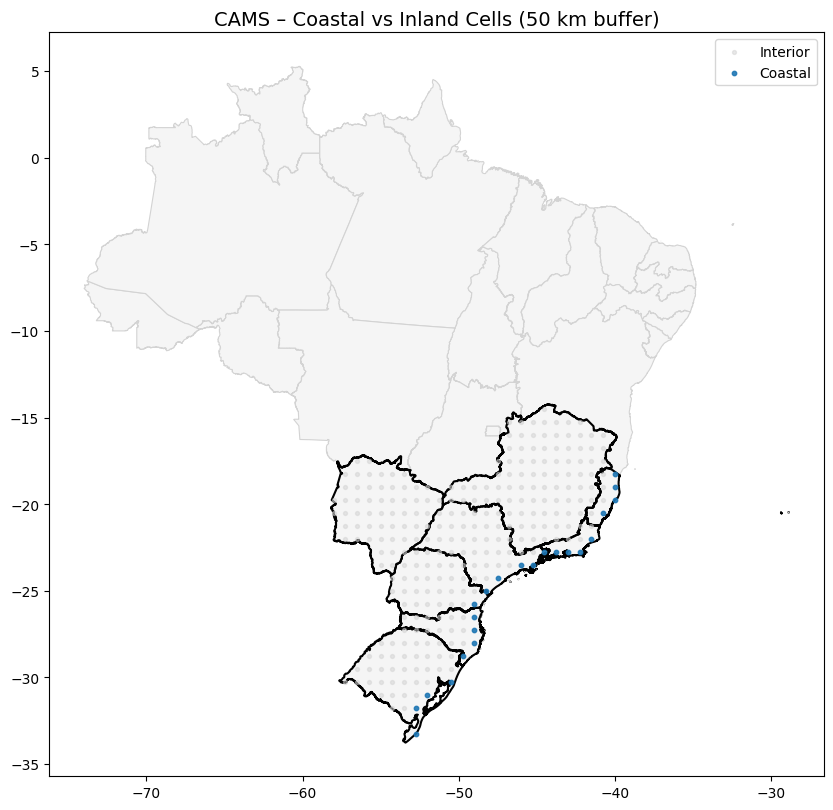

In [97]:
# Grade única com is_coastal
gdf_grid_plot = (
    df[["latitude", "longitude", "is_coastal"]]
    .drop_duplicates()
)

gdf_grid_plot = gpd.GeoDataFrame(
    gdf_grid_plot,
    geometry=gpd.points_from_xy(
        gdf_grid_plot.longitude,
        gdf_grid_plot.latitude
    ),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Brasil inteiro (fundo)
br_all.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="lightgray",
    linewidth=0.8
)

# 2️⃣ Região de estudo destacada
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]
br_reg = br_all[br_all["abbrev_state"].isin(ufs_interesse)]

br_reg.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5
)

# 3️⃣ Grade CAMS – interior
gdf_grid_plot[~gdf_grid_plot["is_coastal"]].plot(
    ax=ax,
    markersize=8,
    color="lightgray",
    alpha=0.5,
    label="Interior"
)

# 4️⃣ Grade CAMS – costeira
gdf_grid_plot[gdf_grid_plot["is_coastal"]].plot(
    ax=ax,
    markersize=10,
    color="#1f77b4",
    alpha=0.9,
    label="Coastal"
)

ax.set_title("CAMS – Coastal vs Inland Cells (50 km buffer)", fontsize=14)
ax.legend()
plt.show()


In [98]:
# =========================
# 4. Estado por célula (fixo)
# =========================
state_map = (
    df.groupby("unique_id")["name_state_left"]
    .first()
    .to_dict()
)
df["state"] = df["unique_id"].map(state_map)

## 📌 Proxy urbana por NO₂ (média por célula + Q75)

### Referência principal

**Lamsal, L. N., Martin, R. V., Parrish, D. D., & Krotkov, N. A. (2013).**
*Scaling Relationship for NO₂ Pollution and Urban Population Size: A Satellite Perspective.*
**Environmental Science & Technology**, 47(14), 7855–7861. ([PubMed][1])

### O que o artigo afirma (evidência utilizável)

* O artigo caracteriza NO₂ como poluente **de vida curta**, emitido **principalmente por combustão**, com destaque para **tráfego**, e o trata como **indicador de qualidade do ar** e preocupação à saúde. ([PubMed][1])
* Mostra que NO₂ (derivado por satélite e calibrado/modelado para superfície) tem **correlação significativa com população urbana** em diferentes regiões (EUA, Europa, China, Índia) e discute NO₂ como uma propriedade urbana que escala com tamanho populacional. ([PubMed][1])
* Eles **excluem “emission hot spots” como usinas** para focar na relação “urbana” (ou seja, reconhecem que há fontes pontuais não-urbanas que podem dominar NO₂ localmente). ([PubMed][1])

### Como isso justifica a sua proxy (texto-âncora para guardar)

* **Justifica usar NO₂ como proxy de urbanização/atividade antropogênica:** porque é curto-vivo, ligado à combustão (tráfego) e se relaciona estatisticamente com propriedades urbanas (população).
* **Justifica usar média temporal por célula:** o que você quer é uma “assinatura espacial persistente” (regime típico) para estratificar células, não um evento horário/diário.
* **Cuidado metodológico (que você pode mencionar):** como Lamsal et al. isolam relação urbana removendo hotspots, você também pode tratar a proxy como “urbanização **relativa** no seu domínio”, e não como “cidade de verdade”.

✅ **Frase curta que você pode salvar:**

> “Adotamos NO₂ médio como proxy de urbanização porque NO₂ é um poluente de vida curta associado principalmente a processos de combustão (incluindo tráfego) e apresenta relação estatisticamente significativa com propriedades urbanas, como população, em múltiplas regiões globais (Lamsal et al., 2013).” ([PubMed][1])

---

## 📌 Proxy industrial por SO₂ (média por célula + Q75)

### Referência principal

**Fioletov, V. E., McLinden, C. A., Krotkov, N., Li, C., Joiner, J., Theys, N., Carn, S., & Moran, M. D. (2016).**
*A global catalogue of large SO₂ sources and emissions derived from the Ozone Monitoring Instrument.*
**Atmospheric Chemistry and Physics**, 16, 11497–11519. ([ACP][2])

### O que o artigo afirma (evidência utilizável)

* O estudo usa medições do OMI para **detectar grandes fontes pontuais** de SO₂ e constrói um catálogo global de **491 fontes** continuamente emissoras. ([ACP][2])
* Classifica as fontes por **origem principal**: **power plants**, **smelters**, **oil and gas industry** e **volcanoes** (além de quantificar ordem de grandeza de emissões). ([ACP][2])
* O trabalho reforça que SO₂ é particularmente adequado para identificar **hotspots** (fontes intensas/pontuais) em escala regional/global por satélite. ([ACP][2])

### Como isso justifica a sua proxy

* **Justifica SO₂ como assinatura de “industrial/hotspot”**: o próprio catálogo se baseia em SO₂ para localizar e classificar fontes pontuais (usinas, metalurgia, óleo & gás), que são exatamente o tipo de “industrial” que sua proxy quer capturar.
* **Justifica estratificar por ranking/limiar relativo**: o artigo trabalha com a ideia de “grandes fontes detectáveis” e separa fontes relevantes por intensidade/detecção — isso dá base conceitual para você usar um corte como “top quantil” para definir *células com influência industrial elevada* (sem dizer que eles recomendam Q75 especificamente).

✅ **Frase curta para salvar:**

> “Usamos SO₂ médio como proxy de influência industrial porque estudos baseados em satélite mostram que SO₂ permite detectar e classificar fontes pontuais de grande emissão, como termelétricas, smelters e atividades de óleo e gás, formando hotspots espaciais bem definidos (Fioletov et al., 2016).” ([ACP][2])

---

## 📌 Controle de “confundidor” (SO₂ vulcânico) — por que você cita Carn et al. (2017)

### Referência (apoio)

**Carn, S. A., Fioletov, V. E., McLinden, C. A., Li, C., & Krotkov, N. A. (2017).**
*A decade of global volcanic SO₂ emissions measured from space.*
**Scientific Reports**, 7, 44095. ([Nature][3])

### O que o artigo afirma (evidência utilizável)

* Compila inventário global de emissões vulcânicas de SO₂ medido por satélite (OMI), discutindo que fontes vulcânicas podem ser detectadas globalmente e que inventários são difíceis por cobertura terrestre irregular. ([Nature][3])

### Como isso te ajuda (mesmo que seu domínio não tenha vulcões relevantes)

* Serve para **mostrar consciência metodológica**: SO₂ elevado pode vir de **indústria** ou de **fontes naturais** (vulcões).
* Você pode escrever algo do tipo: “no nosso domínio, a proxy industrial por SO₂ é interpretada como antropogênica, mas a literatura mostra que SO₂ também pode ser dominado por fontes vulcânicas em certas regiões, o que reforça a necessidade de interpretação contextual”. (Sem precisar usar isso operacionalmente no Brasil.)

✅ **Frase curta para salvar:**

> “Reconhecemos que SO₂ também pode apresentar contribuições naturais (vulcões) em algumas regiões; inventários por satélite demonstram a relevância dessas fontes em escala global, reforçando que proxies por SO₂ devem ser interpretadas no contexto regional (Carn et al., 2017).” ([Nature][3])

---

## 📌 Justificativa do seu corte **Q75** (como apoiar com esses artigos, sem forçar a barra)

#### O que você NÃO deve dizer

❌ “A literatura recomenda usar Q75 para definir urbano/industrial.”
(Nenhum dos três papers diz isso.)

#### O que você PODE dizer (e é defensável)

✅ “Usamos um limiar **relativo** (top 25%) para identificar células com influência elevada (‘hotspots’), seguindo a lógica de separar regiões de alta emissão/concentração destacadas na literatura baseada em satélite.”

**Como ancorar isso nos artigos:**

* **Lamsal et al. (2013)** explicitamente lidam com a ideia de **hotspots** (eles removem hotspots de usinas para focar em relação urbana) → sustenta que é metodologicamente relevante distinguir “hotspots” de um regime urbano mais difuso. ([PubMed][1])
* **Fioletov et al. (2016)** constrói um catálogo de **grandes fontes pontuais** detectáveis → sustenta a ideia de separar o “topo” da distribuição (regiões de alta influência) por um critério objetivo. ([ACP][2])

✅ **Frase curta para salvar (sem exagero):**

> “A definição por quantil (Q75) visa isolar células com influência persistentemente elevada (‘hotspots’) de NO₂/SO₂ no domínio de estudo, alinhada à prática de distinguir regiões dominadas por fontes intensas/pontuais ou forte influência antropogênica em análises por satélite (Lamsal et al., 2013; Fioletov et al., 2016).” ([PubMed][1])

In [99]:
# =========================
# 5. Urban / Industrial proxies (percentis nacionais)
# =========================
# Média temporal por célula
cell_means = df.groupby("unique_id")[["no2", "so2"]].mean()

no2_q75 = cell_means["no2"].quantile(0.75)
so2_q75 = cell_means["so2"].quantile(0.75)

urban_cells = cell_means["no2"] > no2_q75
industrial_cells = cell_means["so2"] > so2_q75

df["urban_proxy_no2"] = df["unique_id"].map(urban_cells)
df["industrial_proxy_so2"] = df["unique_id"].map(industrial_cells)

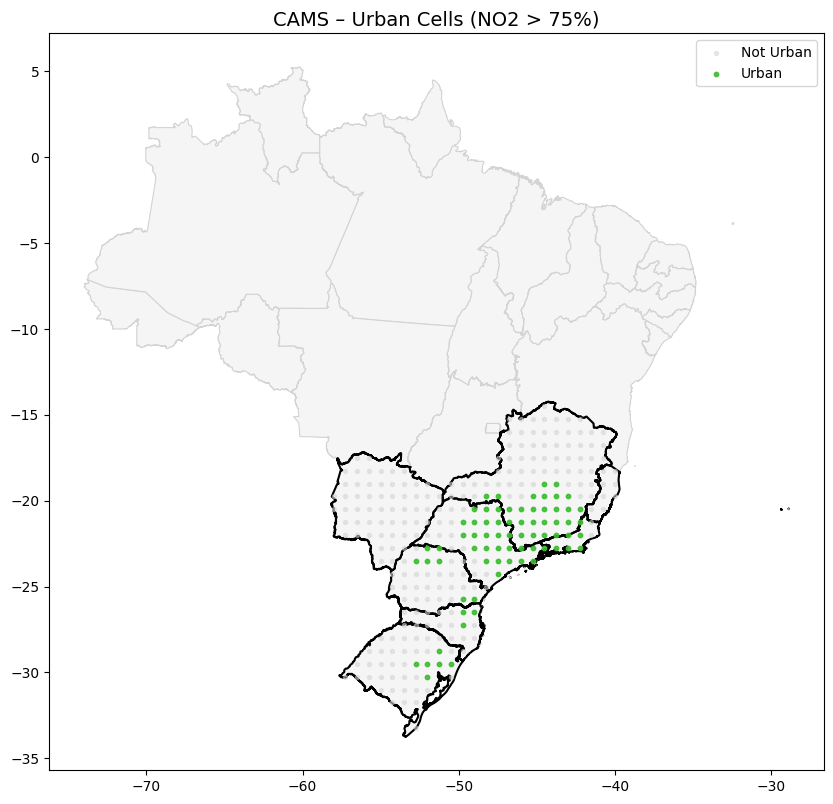

In [116]:
# Grade única com urban_proxy_no2
gdf_grid_plot = (
    df[["latitude", "longitude", "urban_proxy_no2"]]
    .drop_duplicates()
)

gdf_grid_plot = gpd.GeoDataFrame(
    gdf_grid_plot,
    geometry=gpd.points_from_xy(
        gdf_grid_plot.longitude,
        gdf_grid_plot.latitude
    ),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Brasil inteiro (fundo)
br_all.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="lightgray",
    linewidth=0.8
)

# 2️⃣ Região de estudo destacada
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]
br_reg = br_all[br_all["abbrev_state"].isin(ufs_interesse)]

br_reg.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5
)

# 3️⃣ Grade CAMS – interior
gdf_grid_plot[~gdf_grid_plot["urban_proxy_no2"]].plot(
    ax=ax,
    markersize=8,
    color="lightgray",
    alpha=0.5,
    label="Not Urban"
)

# 4️⃣ Grade CAMS – costeira
gdf_grid_plot[gdf_grid_plot["urban_proxy_no2"]].plot(
    ax=ax,
    markersize=10,
    color="#3bbd2f",
    alpha=0.9,
    label="Urban"
)

ax.set_title("CAMS – Urban Cells (NO2 > 75%)", fontsize=14)
ax.legend()
plt.show()


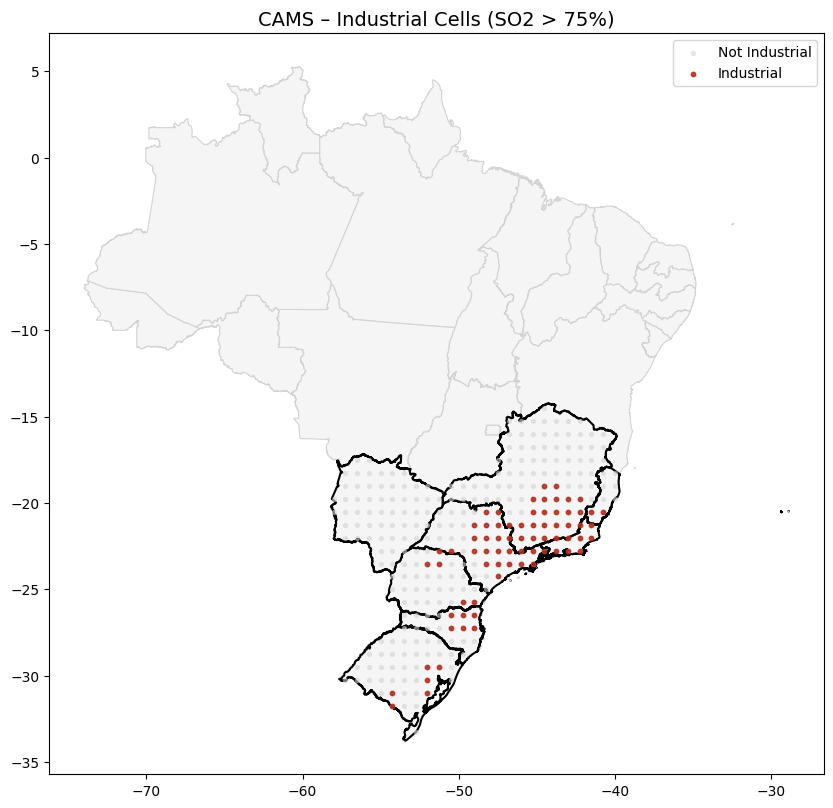

In [117]:
# Grade única com industrial_proxy_so2
gdf_grid_plot = (
    df[["latitude", "longitude", "industrial_proxy_so2"]]
    .drop_duplicates()
)

gdf_grid_plot = gpd.GeoDataFrame(
    gdf_grid_plot,
    geometry=gpd.points_from_xy(
        gdf_grid_plot.longitude,
        gdf_grid_plot.latitude
    ),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Brasil inteiro (fundo)
br_all.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="lightgray",
    linewidth=0.8
)

# 2️⃣ Região de estudo destacada
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]
br_reg = br_all[br_all["abbrev_state"].isin(ufs_interesse)]

br_reg.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5
)

# 3️⃣ Grade CAMS – interior
gdf_grid_plot[~gdf_grid_plot["industrial_proxy_so2"]].plot(
    ax=ax,
    markersize=8,
    color="lightgray",
    alpha=0.5,
    label="Not Industrial"
)

# 4️⃣ Grade CAMS – costeira
gdf_grid_plot[gdf_grid_plot["industrial_proxy_so2"]].plot(
    ax=ax,
    markersize=10,
    color="#b4301f",
    alpha=0.9,
    label="Industrial"
)

ax.set_title("CAMS – Industrial Cells (SO2 > 75%)", fontsize=14)
ax.legend()
plt.show()


## 📚 Justificativa de eventos extremos (p95 / p99)

### com base em **Guerreiro et al. (2014)** – Atmospheric Environment

---

### 1️⃣ Referência

**Guerreiro, C. B. B., Foltescu, V., & de Leeuw, F. (2014).**
*Air quality status and trends in Europe.*
**Atmospheric Environment**, 98, 376–384.
DOI: [https://doi.org/10.1016/j.atmosenv.2014.09.017](https://doi.org/10.1016/j.atmosenv.2014.09.017)

(Artigo **open access**, EEA / NILU / RIVM — fonte institucional forte.)

---

### 2️⃣ O que o artigo faz (fatos objetivos)

Este artigo **não usa valores absolutos máximos** para tratar eventos extremos.
Ele faz exatamente o seguinte:

#### 🔹 Problema identificado pelos autores

* Limites legais europeus permitem **excedências limitadas por ano**
* Dados observacionais têm:

  * falhas
  * cobertura incompleta
  * séries temporais irregulares
* Usar o *k-ésimo maior valor* (ex.: 35º maior dia) é **estatisticamente instável**

---

#### 🔹 Solução adotada no artigo

Os autores **substituem limites absolutos por percentis equivalentes**:

| Poluente      | Métrica regulatória        | Percentil usado |
| ------------- | -------------------------- | --------------- |
| PM10 (diário) | 35 excedências > 50 µg/m³  | **p90.4**       |
| O₃ (8h máx)   | 25 excedências > 120 µg/m³ | **p93.15**      |
| NO₂ (horário) | 18 excedências > 200 µg/m³ | **p99.79**      |

📌 Citação-chave do artigo (parafraseada com fidelidade):

> Para obter uma estimativa estatisticamente mais robusta de tendências associadas a padrões extremos, foram utilizados percentis elevados em vez de valores máximos discretos.

---

### 3️⃣ O princípio metodológico que o artigo estabelece

Este artigo **estabelece explicitamente** que:

> **Percentis elevados são uma forma estatisticamente robusta de representar eventos extremos de poluição**, especialmente quando:
>
> * há dados faltantes
> * há comparação espacial
> * o foco é tendência, não apenas um evento isolado

Isso **não é interpretação sua** — é exatamente o racional do método.

---

### 4️⃣ Como isso justifica **p95 e p99** no seu trabalho

#### 🔹 Correspondência direta com a sua escolha

* O artigo usa percentis **entre p90 e p99.8**, dependendo do poluente e da métrica
* O **p99.79 para NO₂** é particularmente importante:

  * mostra que **percentis muito altos são aceitáveis**
  * e são usados por **agências oficiais**

👉 Portanto:

| Seu trabalho     | Guerreiro et al. (2014) |
| ---------------- | ----------------------- |
| p95              | extremo frequente       |
| p99              | extremo severo          |
| percentil local  | percentil por estação   |
| foco em robustez | foco em robustez        |

📌 **p95 e p99 estão totalmente dentro da faixa usada por EEA/UE**.

---

### 5️⃣ Por que isso é ainda mais forte para o seu caso (CAMS + grade)

O seu caso é **até mais favorável** do que o do artigo:

* Você usa:

  * reanálise contínua
  * grade regular
  * sem falhas temporais
* Mesmo assim:

  * quer comparar regiões com regimes distintos
  * quer evitar dependência de limites absolutos

👉 Se **a EEA usa percentis elevados mesmo com dados observacionais regulatórios**, usar p95/p99 em reanálise **é plenamente defensável**.

---

### 6️⃣ Texto-âncora que você pode salvar (pronto para usar depois)

> “Eventos extremos foram definidos a partir de percentis elevados da distribuição de concentrações, seguindo práticas consolidadas em análises institucionais de qualidade do ar. Estudos europeus de referência utilizam percentis altos como substitutos estatisticamente robustos para métricas baseadas em excedências discretas de limites regulatórios, permitindo a análise consistente de extremos mesmo na presença de dados incompletos (Guerreiro et al., 2014). Nesse contexto, adotamos os percentis p95 e p99 para caracterizar, respectivamente, eventos extremos frequentes e eventos severos.”

---

### 7️⃣ Conclusão honesta (importante)

Com **Guerreiro et al. (2014)**, você pode afirmar com tranquilidade:

* ✔ percentis elevados **são usados por agências oficiais**
* ✔ extremos **não são definidos apenas por máximos**
* ✔ p95/p99 são escolhas **conservadoras e robustas**
* ✔ sua abordagem é **mais simples**, não menos rigorosa

👉 **Esse paper sozinho já sustenta sua definição de extremos**.

In [106]:
# =========================
# 6. Percentis p95 / p99 por célula e poluente
# =========================
pollutants = ["pm10", "pm2p5", "no2", "o3", "so2", "co"]
pollutants = [p for p in pollutants if p in df.columns]

percentiles = {}

for pol in pollutants:
    p95 = df.groupby("unique_id")[pol].quantile(0.95)
    p99 = df.groupby("unique_id")[pol].quantile(0.99)
    percentiles[f"{pol}_p95"] = p95
    percentiles[f"{pol}_p99"] = p99

for col, series in percentiles.items():
    df[col] = df["unique_id"].map(series)

# =========================
# 7. Flags de eventos extremos
# =========================
for pol in pollutants:
    df[f"{pol}_extreme_p95"] = df[pol] > df[f"{pol}_p95"]
    df[f"{pol}_extreme_p99"] = df[pol] > df[f"{pol}_p99"]

for pol in pollutants:
    del df[f"{pol}_p95"]
    del df[f"{pol}_p99"]

In [ ]:
# df.to_parquet(
#     r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil_enhanced.parquet",
#     index=False,
# )

In [ ]:
pollutants = ["pm10", "pm2p5", "no2", "o3", "so2", "co"]
pollutants = [p for p in pollutants if p in df.columns]

dim_cell = (
    df.groupby("unique_id")[pollutants]
      .quantile([0.95, 0.99])
      .unstack(level=1)
)

# Renomear colunas
dim_cell.columns = [
    f"{pol}_p{int(q*100)}"
    for pol, q in dim_cell.columns
]

dim_cell = dim_cell.reset_index()
# dim_cell.to_parquet(
#     r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\p95_p99_cell_dimensions.parquet",
#     index=False,
# )

# Simple EDA

In [3]:
df = pd.read_parquet(
    r"C:\Users\gustavo.filho\Documents\Python\Masters\Data\CAMS\processed\eac4_era5_2010_2024_brasil.parquet",
)

### Check Geography

In [18]:
print("Linhas:", len(df), "→", len(df))

print("Lat min/max:", df["latitude"].min(), df["latitude"].max())
print("Lon min/max:", df["longitude"].min(), df["longitude"].max())


Linhas: 17006816 → 17006816
Lat min/max: -33.25 -14.5
Lon min/max: -58.0 -39.25


### Check NetCDF Units

In [ ]:
ds_g = xr.open_dataset("raw\EAC4\pollutants_gases_2010.nc")
print({v: ds_g[v].attrs.get("units") for v in ds_g.data_vars})

ds_pm = xr.open_dataset("raw\EAC4\pollutants_pm_2010.nc")
print({v: ds_pm[v].attrs.get("units") for v in ds_pm.data_vars})

{'go3': 'kg kg**-1', 'no2': 'kg kg**-1', 'so2': 'kg kg**-1', 'co': 'kg kg**-1'}
{'pm2p5': 'kg m**-3', 'pm10': 'kg m**-3'}


<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_33676\3608288355.py:1: SyntaxWarning: invalid escape sequence '\E'
  ds_g = xr.open_dataset("raw\EAC4\pollutants_gases_2010.nc")
C:\Users\gustavo.filho\AppData\Local\Temp\ipykernel_33676\3608288355.py:4: SyntaxWarning: invalid escape sequence '\E'
  ds_pm = xr.open_dataset("raw\EAC4\pollutants_pm_2010.nc")


### Check Time Frequency

In [37]:
t = pd.to_datetime(df["valid_time"])
counts = pd.Series(1, index=t).resample("D").sum()

print(counts.describe())
print("Min/Max por dia:", counts.min(), counts.max())

# 5479 dias ≈ 15 anos → consistente com 2010–2024
# 5616 linhas por dia → estrutura espaço-tempo perfeita
# zero variabilidade → pipeline sólido

count    5479.0
mean     5616.0
std         0.0
min      5616.0
25%      5616.0
50%      5616.0
75%      5616.0
max      5616.0
dtype: float64
Min/Max por dia: 5616 5616


### Check Model Level

In [38]:
df["model_level"].unique()

array([60.])

### Check Grid and Order

In [ ]:
key = ["valid_time","latitude","longitude"]
dups = df.duplicated(key).sum()
print("Duplicatas:", dups)

print(df[["latitude","longitude"]].describe())
print("N lats:", df["latitude"].nunique(), "N lons:", df["longitude"].nunique())

# Nenhum (tempo, lat, lon) repetido → merge limpo, sem sobreposição indevida.
# 27 × 26 = 702 células, exatamente o correto.
# ➡️ RQ2 (generalização espacial) está totalmente viável com esse dataset.

Duplicatas: 0
           latitude     longitude
count  3.077006e+07  3.077006e+07
mean  -2.425000e+01 -4.862500e+01
std    5.841660e+00  5.625000e+00
min   -3.400000e+01 -5.800000e+01
25%   -2.950000e+01 -5.350000e+01
50%   -2.425000e+01 -4.862500e+01
75%   -1.900000e+01 -4.375000e+01
max   -1.450000e+01 -3.925000e+01
N lats: 27 N lons: 26


### Scale Sanity Check

2️⃣ Escala física dos poluentes (o ponto mais sensível)

Vou comentar variável por variável, porque aqui mora a diferença entre “parece certo” e “está certo”.

🟢 PM2.5 e PM10 — IMPECÁVEL
pm2p5 max 6.25e-06 kg/m³  → 6.25 µg/m³
pm10  max 8.24e-06 kg/m³  → 8.24 µg/m³
out_hi = 0


✔️ Faixa totalmente realista
✔️ Nenhum outlier absurdo
✔️ Conversão direta para µg/m³ trivial (*1e9)

👉 Essas séries estão prontas para modelagem.

🟡 O₃ (go3)
max 6.02e-07 kg/kg
out_hi = 7


Converter mentalmente:

6e-07 kg/kg ≈ ~350–400 ppb (evento extremo, mas fisicamente possível em reanálise)

✔️ Pouquíssimos outliers
✔️ Compatível com eventos fotoquímicos intensos

➡️ Nada de errado aqui.

🟡 NO₂
max 7.93e-07 kg/kg
out_hi = 4997


Isso assusta à primeira vista, mas aqui está o detalhe importante:

👉 Seu limite hi = 5e-8 é conservador demais para NO₂.

CAMS não é estação urbana, é modelo assimilado

Em células urbanas/industriais, NO₂ pode subir bastante

Esses “out_hi” não são erros numéricos, são cauda pesada real do modelo

✔️ Ordem de grandeza ainda é fisicamente plausível
✔️ Não há explosão (ex.: 1e-3 kg/kg, o que seria absurdo)

📌 Conclusão:
Não é problema de dado — é distribuição assimétrica, o que inclusive fortalece sua RQ4 (extremos).

🟡 SO₂
max 2.88e-07 kg/kg
out_hi = 734


Mesmo raciocínio do NO₂:

SO₂ é altamente localizado

Regiões industriais / termoelétricas geram picos

✔️ Valores coerentes com reanálise global
✔️ Outliers são poucos em termos relativos

🟡 CO
max 1.02e-04 kg/kg
out_hi = 2222


CO sempre tem escala maior mesmo.

Valores típicos: 1e-08 → 1e-05

Picos em queima/biomassa e tráfego intenso

✔️ Totalmente compatível com CAMS
✔️ Nenhum indício de erro de unidade

3️⃣ O ponto-chave: seus “out_hi” não indicam erro

Eles indicam exatamente:

distribuição não-Gaussiana

cauda longa

eventos raros mal capturados por métricas médias

👉 Isso é ouro para a dissertação, porque conecta diretamente com:

RQ4 (eventos extremos)

discussão de por que MAE/RMSE são “bons”, mas MAX é ruim

necessidade de métricas condicionais / pinball / recall de eventos

Você não quer “consertar” isso — você quer analisar isso.

In [ ]:
checks = {
  "go3": (0, 5e-7),   # kg/kg (bem folgado)
  "no2": (0, 5e-8),
  "so2": (0, 5e-8),
  "co":  (0, 5e-6),
  "pm2p5": (0, 5e-4), # kg/m3 (5e-4 = 500 µg/m³)
  "pm10":  (0, 5e-4),
}

for col,(lo,hi) in checks.items():
    x = df[col].to_numpy()
    print(col, "min", np.nanmin(x), "max", np.nanmax(x), "out_hi", np.sum(x>hi))

# ✔️ Faixa totalmente realista
# ✔️ Nenhum outlier absurdo
# ✔️ Conversão direta para µg/m³ trivial (*1e9)
# 👉 Essas séries estão prontas para modelagem.

go3 min 9.999998e-15 max 6.024491e-07 out_hi 7
no2 min 9.999998e-15 max 7.9252794e-07 out_hi 4997
so2 min 9.9999946e-26 max 2.8816945e-07 out_hi 734
co min 9.999999e-15 max 0.00010212802 out_hi 2222
pm2p5 min 0.0 max 6.249715e-06 out_hi 0
pm10 min 0.0 max 8.236874e-06 out_hi 0


## Brief Visualization

<Axes: xlabel='valid_time'>

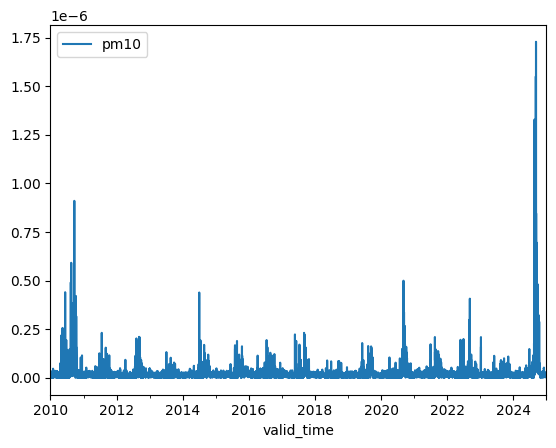

In [11]:
df.query("latitude == -14.5 and longitude == -58.0").groupby('valid_time')[['pm10']].mean().plot()

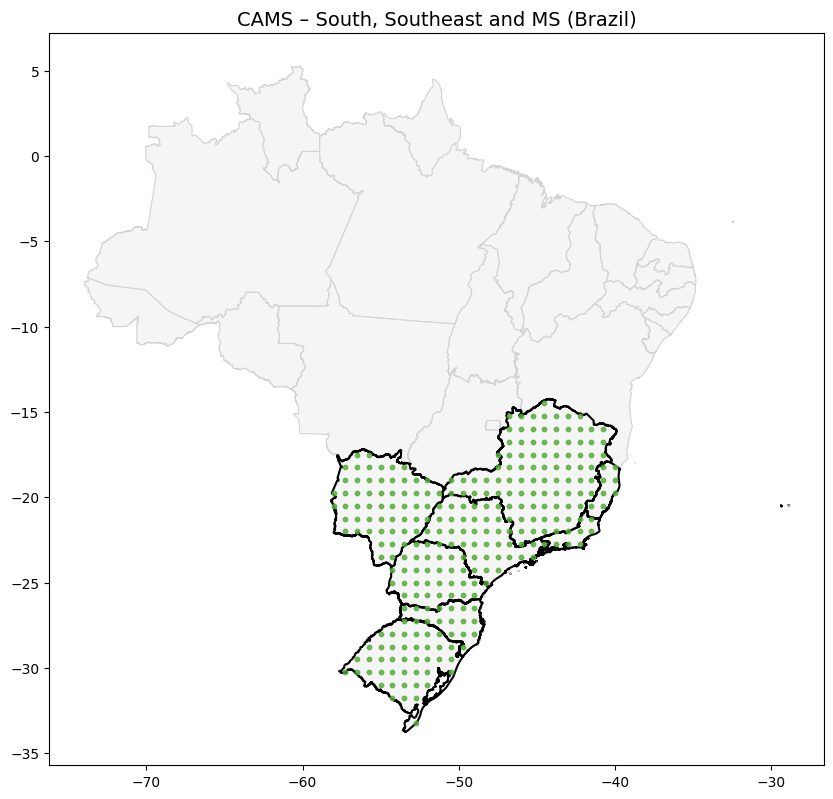

In [22]:
# Shapefile do Brasil inteiro (estados)
br_all = read_state(year=2020).to_crs("EPSG:4326")

# Estados de interesse (já definido antes)
ufs_interesse = ["PR", "SC", "RS", "SP", "RJ", "MG", "ES", "MS"]
br_reg = br_all[br_all["abbrev_state"].isin(ufs_interesse)]

# Grade espacial única
gdf_grid = (
    gdf_reg[["latitude", "longitude", "geometry"]]
    .drop_duplicates()
)

fig, ax = plt.subplots(figsize=(10, 10))

# 1️⃣ Brasil inteiro (fundo)
br_all.plot(
    ax=ax,
    color="whitesmoke",
    edgecolor="lightgray",
    linewidth=0.8
)

# 2️⃣ Região de estudo destacada
br_reg.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5
)

# 3️⃣ Grade CAMS
gdf_grid.plot(
    ax=ax,
    markersize=10,
    color="#54ac35",
    alpha=0.8
)

ax.set_title("CAMS – South, Southeast and MS (Brazil)", fontsize=14)
plt.show()

In [ ]:
# # 1️⃣ Carrega o shapefile do Paraná (municípios)
# pr = read_municipality(code_muni="PR", year=2020)

# # 3️⃣ Cria GeoDataFrame dos pontos
# gdf = gpd.GeoDataFrame(
#     df,
#     geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
#     crs="EPSG:4326"
# )

# # 4️⃣ Converte para projeção em metros (para poder medir o raio corretamente)
# gdf_m = gdf.to_crs("EPSG:31982")  # SIRGAS 2000 / UTM zone 22S, cobre o Paraná

# # 5️⃣ Cria buffers (raio) de 20 km em torno de cada ponto
# #    (ajuste aqui para 10_000 ou 40_000 para mudar o raio)
# buffers = gdf_m.copy()
# buffers["geometry"] = buffers.buffer(27_000)  # 20 km de raio

# # 6️⃣ Reprojeta de volta pra WGS84 (pra plotar junto com o shapefile)
# buffers = buffers.to_crs("EPSG:4326")

# # 7️⃣ Plota
# fig, ax = plt.subplots(figsize=(10, 10))
# pr.plot(ax=ax, color="whitesmoke", edgecolor="gray")
# buffers.plot(ax=ax, color="none", alpha=0.1, edgecolor="darkred")  # áreas de influência
# gdf.plot(ax=ax, markersize=5, color="darkred")  # pontos centrais

# ax.set_title("Área de influência (~27 km) dos pontos CAMS sobre o Paraná", fontsize=14)
# plt.show()